We gather volumes (npy 3D files), inspect them a little bitto, draw some random graphs, brew little coffee, munch some nuts and chocolate drops, and rescale our data in appropriate range so we can compare them.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

def enhance_volume(volume, percetile_left, percentile_right, gamma):
    """
    Enhance the blobs in a 3D volume by normalizing, applying contrast stretching, 
    and using gamma correction.
    
    Parameters:
    - volume: numpy array of shape (D, H, W)
    - gamma: float, gamma correction factor (>1 to emphasize higher intensities)
    
    Returns:
    - enhanced_volume: numpy array with values between 0 and 1
    """
    # Step 1: Min-Max Normalization
    volume_normalized = (volume - np.min(volume)) / (np.max(volume) - np.min(volume))

    # Step 2: Contrast Stretching
    p1, p2 = np.percentile(volume_normalized, (percetile_left, percentile_right))
    volume_contrast = exposure.rescale_intensity(volume_normalized, in_range=(p1, p2))
    
    # Step 3: Gamma Correction
    volume_gamma = exposure.adjust_gamma(volume_contrast, gamma)
    
    return volume_gamma

def adjust_gamma(volume, gamma):
    """
    Normalize volume beteen 0 and 1, and apply gamma correction.
    """
    volume_normalized = (volume - np.min(volume)) / (np.max(volume) - np.min(volume))
    volume_gamma = exposure.adjust_gamma(volume_normalized, gamma)
    return volume_gamma

def load_volume(data_path):
    return np.load(data_path)

def min_max_mean(volume, title='Volume ?'):
    print('+---', title, '---+')
    print(f'min: {np.min(volume)}')
    print(f'max: {np.max(volume)}')
    print(f'mean: {np.mean(volume)}')
    print()

def plot_histograms(volume_list, bins=50, labels=None, colors=None, alpha=0.5, log=True):
    if labels is None:
        labels = [f'Volume {i+1}' for i in range(len(volume_list))]
    if colors is None:
        colors = plt.cm.tab10.colors
    plt.figure(figsize=(8, 4))
    for i, arr in enumerate(volume_list):
        color = colors[i % len(colors)]
        plt.hist(arr.flatten(), bins=bins, label=labels[i], color=color, alpha=alpha, edgecolor='black', log=log)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histograms of 3D Volumes')
    plt.legend()
    plt.grid(True)
    plt.show()

def save_volumes(volumes, volume_names, path='../data/z-bin'):
    for i in range(len(volume_names)):
        np.save(f'{path}/{volume_names[i]}.npy', volumes[i])
    print('Saved.')

def normalize_to_01(volume):
    """Normalize a 3D NumPy array to the range [0, 1]."""
    v_min = np.min(volume)
    v_max = np.max(volume)
    return (volume - v_min) / (v_max - v_min)

def clip_and_normalize(volume, min_percentile=1, max_percentile=99):
    """Clip outliers based on percentiles and normalize to [0, 1]."""
    lower_bound = np.percentile(volume, min_percentile)
    upper_bound = np.percentile(volume, max_percentile)
    clipped_volume = np.clip(volume, lower_bound, upper_bound)
    return normalize_to_01(clipped_volume)


This is a constrast enhancement of GT data (CT reconstructed by acquisition team).

In [2]:
#vol1 = load_volume('../data/battery/3_clear/ct_volume/volume_block_crop.npy')
vol = load_volume('../data/z-volumes/fbp/volume_fbp_inter.npy')
print(f'loaded volume with shape {vol.shape}')

loaded volume with shape (256, 256, 256)


You may want to crop the internal cuboid--final shape 256x160x160 (DxHxW).

In [10]:
center = [dim // 2 for dim in vol.shape] # center coordinates
radius = 128
angle = np.pi/4
margin = 10

side = 2 * radius * np.cos(angle)

offset_depth = 128
offset_height = int(side / 2)
offset_width = int(side / 2)

cropped_volume = vol[
    center[0] - offset_depth: center[0] + offset_depth,
    center[1] - offset_height + margin: center[1] + offset_height - margin,
    center[2] - offset_width + margin: center[2] + offset_width - margin,
]
cropped_volume.shape

(256, 160, 160)

In [11]:
np.save('../data/z-volumes/fbp/volume_fbp_inter_crop.npy', cropped_volume)
print('saved the cropped volume')

saved the cropped volume


In [12]:
vol = cropped_volume

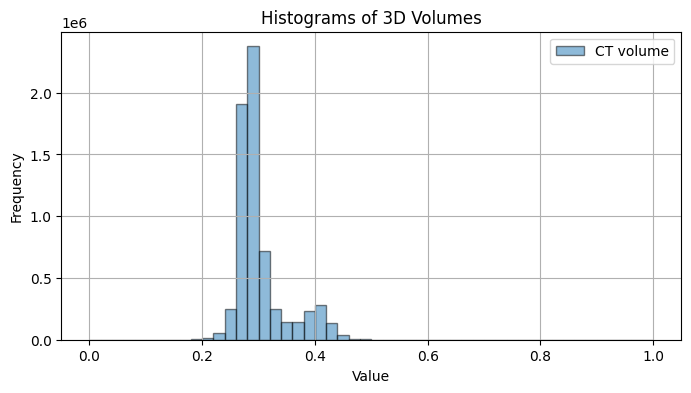

In [13]:
norm_vol = normalize_to_01(vol)
plot_histograms([norm_vol], labels=['CT volume'], log=False)

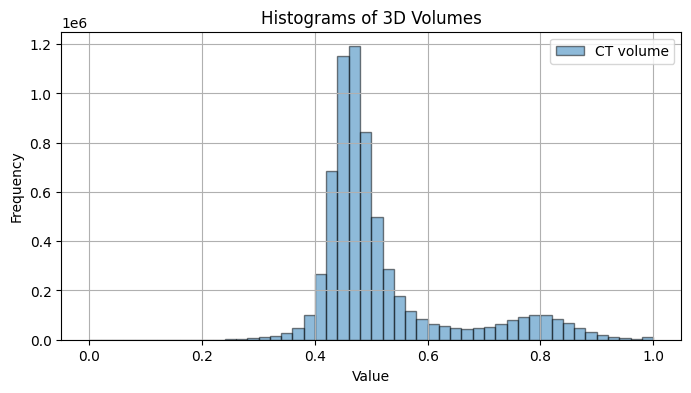

In [22]:
norm_vol_enh = enhance_volume(norm_vol, percetile_left=0, percentile_right=99.9, gamma=1.5)
plot_histograms([norm_vol_enh], labels=['CT volume'], log=False)

Here we may want to suppress background noise using K-means (k=2)

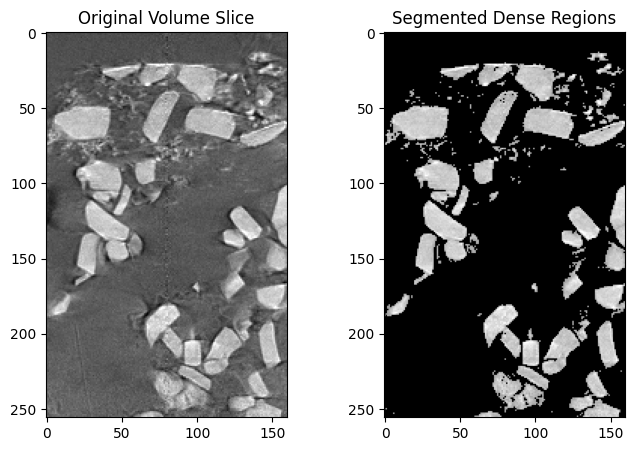

In [29]:
from sklearn.cluster import KMeans

volume = norm_vol_enh

# Reshape the volume into a 1D array for clustering
flattened_volume = volume.reshape(-1, 1)

# Apply K-Means clustering with k=2
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels = kmeans.fit_predict(flattened_volume)

# Determine which cluster corresponds to the background (lower intensity)
background_label = np.argmin(kmeans.cluster_centers_)

# Create a mask where background is set to zero
segmented_volume = volume.copy()
segmented_volume[labels.reshape(volume.shape) == background_label] = 0

# Visualization of a middle slice for verification
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.imshow(volume[:, :, volume.shape[2] // 2], cmap='gray')
plt.title("Original Volume Slice")

plt.subplot(1, 2, 2)
plt.imshow(segmented_volume[:, :, segmented_volume.shape[2] // 2], cmap='gray')
plt.title("Segmented Dense Regions")

plt.show()

In [30]:
save_volumes([segmented_volume], ['fbp_crop_enh_seg'], path='../data/z-volumes/fbp/')

Saved.


So, regarding the GT volume with FBP, here is a little recap.
- we cropped the inner region (volume_fbp_inter_crop.npy)
- we did volume ehancement (fbp_crop_enh.npy)
- we apply binary treshold using k-means (fbp_crop_enh_seg.npy)

So, at the end of the day, fbp_crop_enh_seq.npy is our final refined ground truth (256x160x160)

Enhance the volume by R2Gaussian

In [2]:
#vol = load_volume('../data/z-volumes/r2gaus/180_avg/180_avg_r2gaus.npy')
vol = load_volume('../data/id_volumes/id_22.npy')
print(f'loaded volume with shape {vol.shape}')

loaded volume with shape (256, 256, 256)


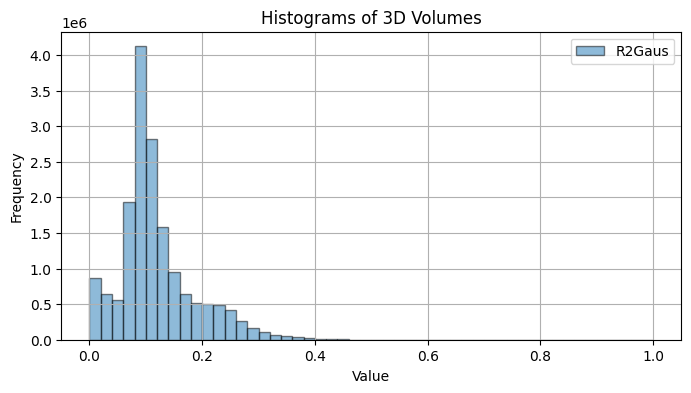

In [3]:
norm_vol = normalize_to_01(vol)
plot_histograms([norm_vol], labels=['R2Gaus'], log=False)

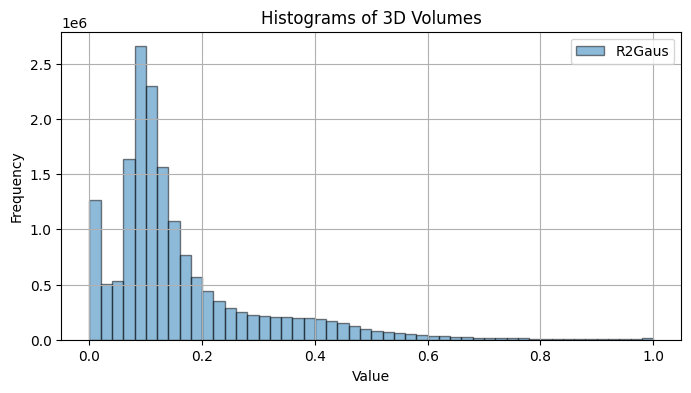

In [6]:
norm_vol_enh = enhance_volume(norm_vol, percetile_left=0, percentile_right=99.9, gamma=1.5)
plot_histograms([norm_vol_enh], labels=['R2Gaus'], log=False)

In [7]:
#save_volumes([norm_vol_enh], ['r2gaus_enh'], path='../data/z-volumes/r2gaus/')
save_volumes([norm_vol_enh], ['id_22_enh'], path='../data/id_volumes/')

Saved.


Enhance volume of SaxNerf generated volumes.

In [3]:
vol = load_volume('../data/z-bin/battery/exp_1/method_3/image_pred_exp.npy')
print(f'loaded volume with shape {vol.shape}')

loaded volume with shape (256, 256, 256)


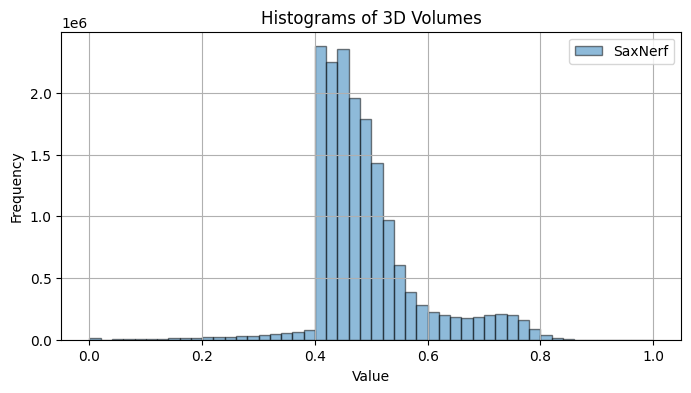

In [4]:
norm_vol = normalize_to_01(vol)
plot_histograms([norm_vol], labels=['SaxNerf'], log=False)

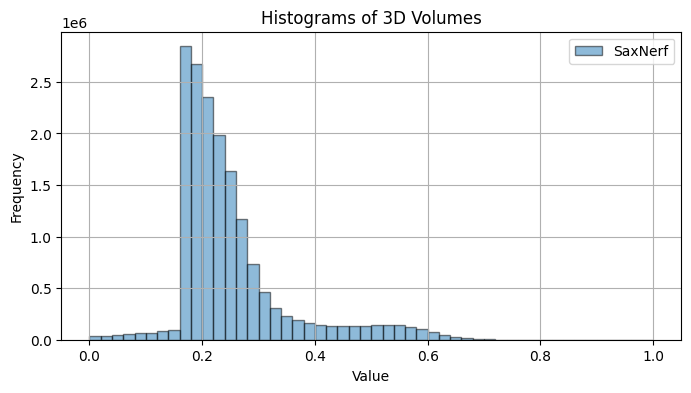

In [5]:
norm_vol_enh = enhance_volume(norm_vol, percetile_left=0, percentile_right=100, gamma=2.0)
plot_histograms([norm_vol_enh], labels=['SaxNerf'], log=False)

In [7]:
save_volumes([norm_vol_enh], ['image_pred_enh'], path='../data/z-bin/battery/exp_1/method_3')

Saved.


## Experiment 1 - Less samples

### SaxNef

In [2]:
exp_name = 'exp_1'
model_name = 'saxnerf'

# First volume
volume_name = 'crop_volume_45.npy'
data_path = f'../data/battery/4_battery_clean_crops/{exp_name}/{model_name}/{volume_name}'
vol1 = load_volume(data_path)

# Second volume
volume_name = 'crop_volume_90.npy'
data_path = f'../data/battery/4_battery_clean_crops/{exp_name}/{model_name}/{volume_name}'
vol2 = load_volume(data_path)

# Third volume
volume_name = 'crop_volume_180.npy'
data_path = f'../data/battery/4_battery_clean_crops/{exp_name}/{model_name}/{volume_name}'
vol3 = load_volume(data_path)

In [2]:
# Volume of 180 averaged projections
volume_name = '180_no_avg_saxnerf_cropped.npy'
data_path = f'../data/z-volumes/saxnerf/180_no_avg/{volume_name}'
vol1 = load_volume(data_path)

In [3]:
# Volume 1
norm_vol1 = adjust_gamma(vol1, 1.0)
save_volumes([norm_vol1], ['180_no_avg_saxnerf_enh'], path='../data/z-volumes/saxnerf/180_no_avg')

Saved.


In [33]:
# Volume 2
norm_vol2 = adjust_gamma(vol2, 1.5)
save_volumes([norm_vol2], ['vol_90'])

Saved.


In [3]:
# Volume 3
norm_vol3 = adjust_gamma(vol3, 1.0)
save_volumes([norm_vol3], ['vol_180'])

Saved.


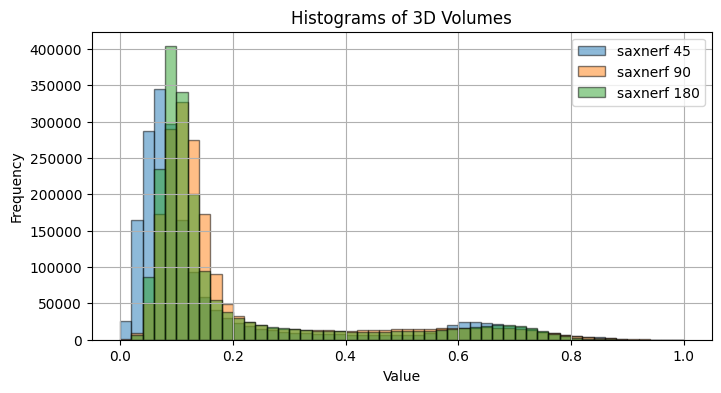

In [34]:
plot_histograms([norm_vol1, norm_vol2, norm_vol3], labels=['saxnerf 45', 'saxnerf 90', 'saxnerf 180'], log=False)

### R2Gaussian

In [4]:
exp_name = 'exp_1'
model_name = 'r2gaus'

# First volume
volume_name = 'crop_volume_45.npy'
data_path = f'../data/battery/4_battery_clean_crops/{exp_name}/{model_name}/{volume_name}'
vol1 = load_volume(data_path)

# Second volume
volume_name = 'crop_volume_90.npy'
data_path = f'../data/battery/4_battery_clean_crops/{exp_name}/{model_name}/{volume_name}'
vol2 = load_volume(data_path)

# Third volume
volume_name = 'crop_volume_180.npy'
data_path = f'../data/battery/4_battery_clean_crops/{exp_name}/{model_name}/{volume_name}'
vol3 = load_volume(data_path)

In [4]:
# Volume of 180 averaged projections
volume_name = '180_no_avg_r2gaus_cropped.npy'
data_path = f'../data/z-volumes/r2gaus/180_no_avg/mini/{volume_name}'
vol1 = load_volume(data_path)

In [5]:
# Volume 1
norm_vol1 = enhance_volume(vol1, percetile_left=0, percentile_right=99.9, gamma=1.5)
save_volumes([norm_vol1], ['180_avg_r2gaus_enh'], path='../data/z-volumes/r2gaus/180_no_avg/mini/')

Saved.


In [37]:
# Volume 2
norm_vol2 = enhance_volume(vol2, percetile_left=0, percentile_right=99.9, gamma=1.5)
save_volumes([norm_vol2], ['vol_90'])

Saved.


In [5]:
# Volume 3
norm_vol3 = enhance_volume(vol3, percetile_left=0, percentile_right=99.9, gamma=1.5)
save_volumes([norm_vol3], ['vol_180'])

Saved.


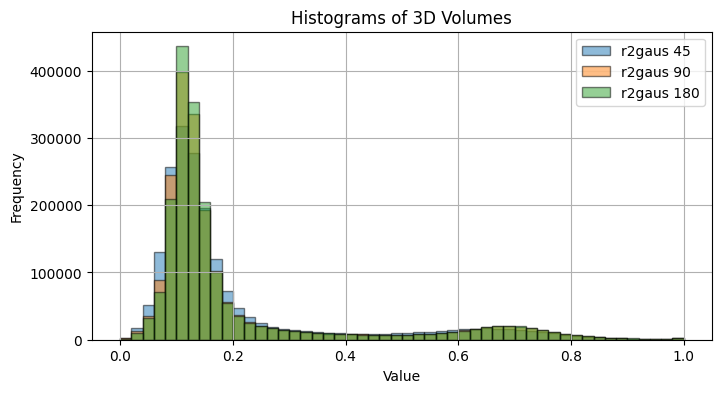

In [40]:
plot_histograms([norm_vol1, norm_vol2, norm_vol3], labels=['r2gaus 45', 'r2gaus 90', 'r2gaus 180'], log=False)

## Experiment 2 - Narrow angles

### SaxNerf

In [57]:
exp_name = 'exp_2'
model_name = 'saxnerf'

# First volume
volume_name = 'crop_volume_30_150.npy'
data_path = f'../data/battery/4_battery_clean_crops/{exp_name}/{model_name}/{volume_name}'
vol1 = load_volume(data_path)

# Second volume
volume_name = 'crop_volume_45_135.npy'
data_path = f'../data/battery/4_battery_clean_crops/{exp_name}/{model_name}/{volume_name}'
vol2 = load_volume(data_path)

# Third volume
volume_name = 'crop_volume_60_120.npy'
data_path = f'../data/battery/4_battery_clean_crops/{exp_name}/{model_name}/{volume_name}'
vol3 = load_volume(data_path)

In [58]:
# Volume 1
norm_vol1 = adjust_gamma(vol1, 1.2)
save_volumes([norm_vol1], ['vol_30_150'])

Saved.


In [59]:
# Volume 2
norm_vol2 = adjust_gamma(vol2, 1.2)
save_volumes([norm_vol2], ['vol_45_135'])

Saved.


In [60]:
# Volume 3
norm_vol3 = adjust_gamma(vol3, 1.0)
save_volumes([norm_vol3], ['vol_60_120'])

Saved.


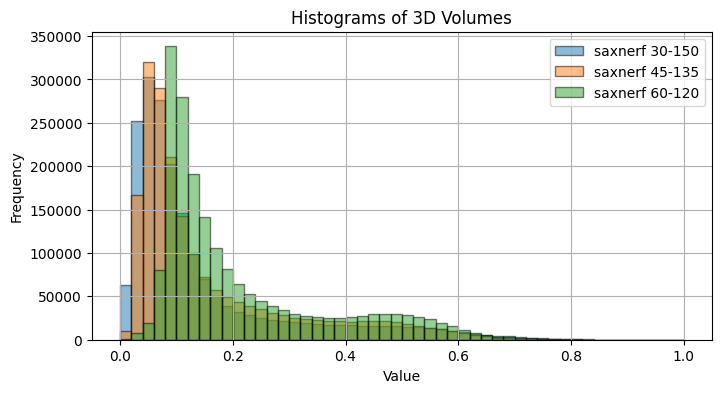

In [61]:
plot_histograms([norm_vol1, norm_vol2, norm_vol3], labels=['saxnerf 30-150', 'saxnerf 45-135', 'saxnerf 60-120'], log=False)

### R2Gaussian

In [62]:
exp_name = 'exp_2'
model_name = 'r2gaus'

# First volume
volume_name = 'crop_volume_30_150.npy'
data_path = f'../data/battery/4_battery_clean_crops/{exp_name}/{model_name}/{volume_name}'
vol1 = load_volume(data_path)

# Second volume
volume_name = 'crop_volume_45_135.npy'
data_path = f'../data/battery/4_battery_clean_crops/{exp_name}/{model_name}/{volume_name}'
vol2 = load_volume(data_path)

# Third volume
volume_name = 'crop_volume_60_120.npy'
data_path = f'../data/battery/4_battery_clean_crops/{exp_name}/{model_name}/{volume_name}'
vol3 = load_volume(data_path)

In [63]:
# Volume 1
norm_vol1 = enhance_volume(vol1, percetile_left=0, percentile_right=99.9, gamma=2.0)
save_volumes([norm_vol1], ['1'])

Saved.


In [64]:
# Volume 2
norm_vol2 = enhance_volume(vol2, percetile_left=0, percentile_right=99.9, gamma=1.2)
save_volumes([norm_vol2], ['2'])

Saved.


In [71]:
# Volume 3
norm_vol3 = enhance_volume(vol3, percetile_left=0, percentile_right=99.9, gamma=1.2)
save_volumes([norm_vol3], ['3'])

Saved.


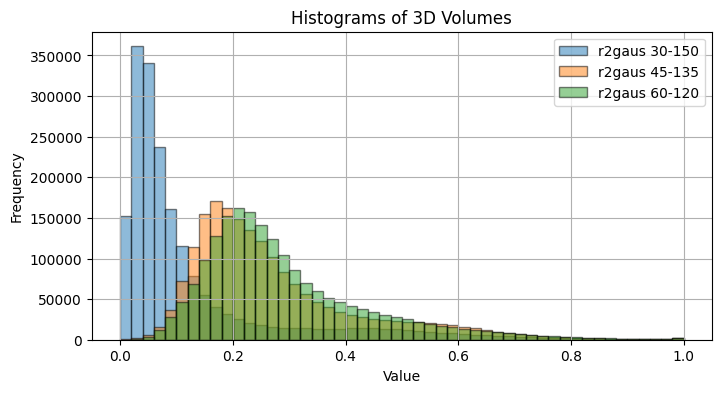

In [66]:
plot_histograms([norm_vol1, norm_vol2, norm_vol3], labels=['r2gaus 30-150', 'r2gaus 45-135', 'r2gaus 60-120'], log=False)

## Clustering

Trye different k and discriminate between high and low density regions.

Saved.


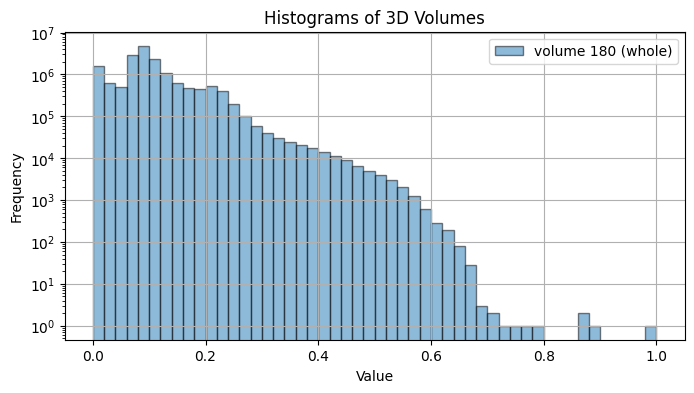

In [4]:
# Gathering the whole volume
exp_name = 'exp_1'
model_name = 'r2gaus'

# First volume
volume_name = 'volume_180.npy'
data_path = f'../data/battery/4_battery_clean_crops/{exp_name}/{model_name}/{volume_name}'
vol1 = load_volume(data_path)

# Normalize
vol1 = normalize_to_01(vol1)
#vol1 = enhance_volume(vol1, percetile_left=0, percentile_right=99.9, gamma=1.0)
save_volumes([vol1], ['volume_180_enh'])

plot_histograms([vol1], labels=['volume 180 (whole)'])

In [13]:
# Gathering the cropped volume

data_path = f'../data/id_volumes/id_22_crop_enh.npy'
vol1 = load_volume(data_path)

#norm_vol1 = enhance_volume(vol1, percetile_left=0, percentile_right=99.9, gamma=1.5)
#save_volumes([norm_vol1], ['cropped_enh'])
print(vol1.shape)

(256, 160, 160)


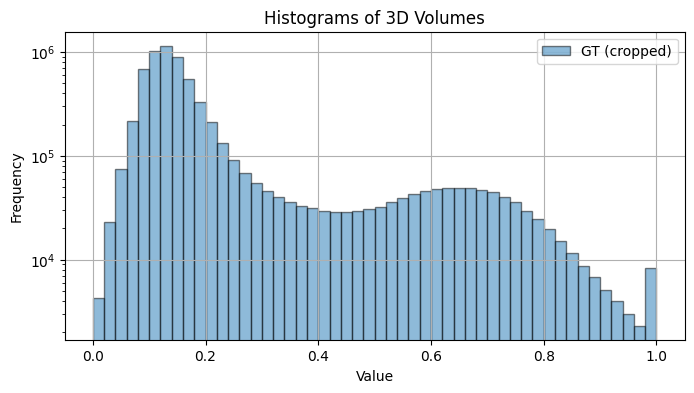

In [15]:
plot_histograms([vol1], labels=['GT (cropped)'])

In [16]:
import numpy as np
from scipy.ndimage import gaussian_filter, binary_closing, binary_opening
from sklearn.cluster import KMeans, DBSCAN
import napari
from tqdm import tqdm

# the here the 3D volume you want to cluster
volume = vol1

# Step 1: Denoise the volume
denoised_volume = gaussian_filter(volume, sigma=1)

# Step 2: Reshape the volume for clustering
reshaped_volume = denoised_volume.reshape(-1, 1)

# Step 3: K-means clustering
kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
labels = kmeans.fit_predict(reshaped_volume)

# Reshape labels back to the original volume shape
segmented_volume = labels.reshape(volume.shape)

# Step 4: Refine segmentation with morphological operations
cleaned_volume = binary_closing(segmented_volume, structure=np.ones((3, 3, 3)))
cleaned_volume = binary_opening(cleaned_volume, structure=np.ones((3, 3, 3)))

#cleaned_volume[cleaned_volume != 0] = 0
#cleaned_volume = segmented_volume
print(np.unique(cleaned_volume))

# Visualize with napari
viewer = napari.Viewer()
viewer.add_image(volume, name='Original Volume', colormap='twilight_shifted')
viewer.add_labels(cleaned_volume, name='Segmented Stones')
napari.run()

save_volumes([cleaned_volume], ['2-means'])

[False  True]
Saved.


In [10]:
kmeans.cluster_centers_

array([[0.13997382],
       [0.6062517 ]], dtype=float32)

Elbow method. We plot the Within-Cluster Sum of Squares (WCSS) against different k values.

Inertia:
- is the measure of how well the data points are clustered around their respective cluster centers
- sum of squared distances between each data point and the centroid of the cluster it belongs to
- it quantifies the compactness of the cluster
- as k increases, inertia decreases because with more clusters, data points are closer to their centroids
- the elbow point represent a value of k where the inertia begins to decrease more slowly 

100%|██████████| 9/9 [00:47<00:00,  5.23s/it]


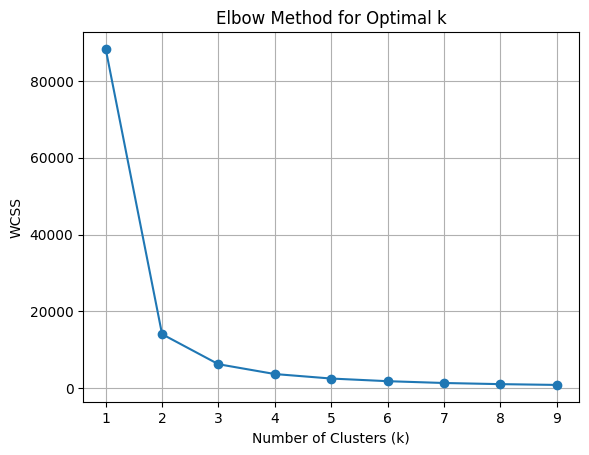

In [78]:
wcss = []
for i in tqdm(range(1, 10)):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=42)
    kmeans.fit(reshaped_volume)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 10), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.grid()
plt.show()